In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import json

import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import ticker
import scipy.signal as sig

import flim_processing as fp
import flim_analysis as fa
import flim_geometry as fg
import flim_chemistry as fc
import flim_ui as fui
from ivium import IviumFile

mass_particle_AC = 0.35e-6
radius_particle_AC = 454.5e-6
surface_area_AC = 2.6e-6
volume_AC = 39.46e-9
diff_OH = 5.270e-9
area_channel = 4e-3**2
nu_water = 1e-6
pixel_size = 9.09

In [2]:
data_folder = r"D:\[Code]\paper01\data"
figures_folder = r"D:\[Code]\paper01\figures"

# Loading Current Data

In [3]:
"""FLIM data"""
current_data = fp.open_flim(
    os.path.join(data_folder, "current_p.npz"),
    property_modifications={"lifetime_phase": 1000, "value": 1000},
)

"""Features"""
current_features = fg.load_features(
    data_folder, "current_features.shp", "current_features.npz"
)

"""Open flim .json"""
with open(os.path.join(data_folder, "current.json"), "r") as file:
    current_info = json.load(file)
current_timestamps_flim = np.array(
    list(current_info["FLIMIMAGE"]["TIMESTAMPS in ms"].values())
)
current_delta_t_flim = current_timestamps_flim[1] * 1e-3

"""Load Potential and Current data from ivium file"""
current_ivium = IviumFile()
current_ivium.set_path(os.path.join(data_folder, "current_ivium1420.csv"))
current_ivium.read_data_from_file()

"""Timestamps"""
current_time_stamps = np.array([1000, 180, 240, 300, 360, 420, 480, 540, 600, 660])
current_flim_frames = fp.timestamp2frame_flim(
    current_time_stamps, current_info, offset_flim=-5
)["flim_frames"]

In [4]:
current_particle = [f for f in current_features if f.name == "particle"][0]
current_wall = [f for f in current_features if f.name == "wall"][0]
current_membrane = [f for f in current_features if f.name == "membrane"][0]
current_volume = [f for f in current_features if f.name == "volume"][0]

extent = fa.get_extent(current_data["value"][0], 9.09, 1e-3)
geom_extent = [
    0,
    current_data["intensity"][0].shape[1],
    0,
    current_data["intensity"][0].shape[0],
]

# Loading Flow Data

In [40]:
"""FLIM data"""
flow_data = fp.open_flim(
    os.path.join(data_folder, "flow_p.npz"),
    property_modifications={"lifetime_phase": 1000, "value": 1000},
)

"""Features"""
flow_features = fg.load_features(data_folder, "flow_features.shp", "flow_features.npz")

"""Open flim .json"""
with open(os.path.join(data_folder, "current.json"), "r") as file:
    flow_info = json.load(file)
flow_timestamps_flim = np.array(
    list(flow_info["FLIMIMAGE"]["TIMESTAMPS in ms"].values())
)
flow_delta_t_flim = flow_timestamps_flim[1] * 1e-3

"""Load Potential and Current data from ivium file"""
flow_ivium = IviumFile()
flow_ivium.set_path(os.path.join(data_folder, "flow_ivium1430.csv"))
flow_ivium.read_data_from_file()

"""Timestamps"""
flow_time_stamps = np.array([0, 1, 2, 3, 4, 5, 6, 7]) * 60
t_start = 5  # seconds
t_offset = 55
delta_t = 10
t_eval = flow_time_stamps + t_start + t_offset
flow_flim_frames = fp.timestamp2frame_flim(
    t_eval, flim_info=current_info, offset_flim=-t_start
)["flim_frames"][::-1]
flows = np.array([2, 1.5, 1.2, 1, 0.8, 0.5, 0.3, 0.1])[::-1]
Res = flows / 60 * 1e-6 / area_channel * 2 * radius_particle_AC / nu_water

In [41]:
print(flows)
print(flow_flim_frames)

[0.1 0.3 0.5 0.8 1.  1.2 1.5 2. ]
[484, 424, 364, 304, 245, 185, 125, 65]


In [17]:
flow_particle = [f for f in flow_features if f.name == "particle"][0]
flow_wall = [f for f in flow_features if f.name == "wall"][0]
flow_membrane = [f for f in flow_features if f.name == "membrane"][0]
flow_volume = [f for f in flow_features if f.name == "volume"][0]

# Figure 4

0 -14.1782
1 -42.768857142857144
2 -142.80285714285716
0 484 0.09468750000000001
2 364 0.4734375
7 65 1.89375


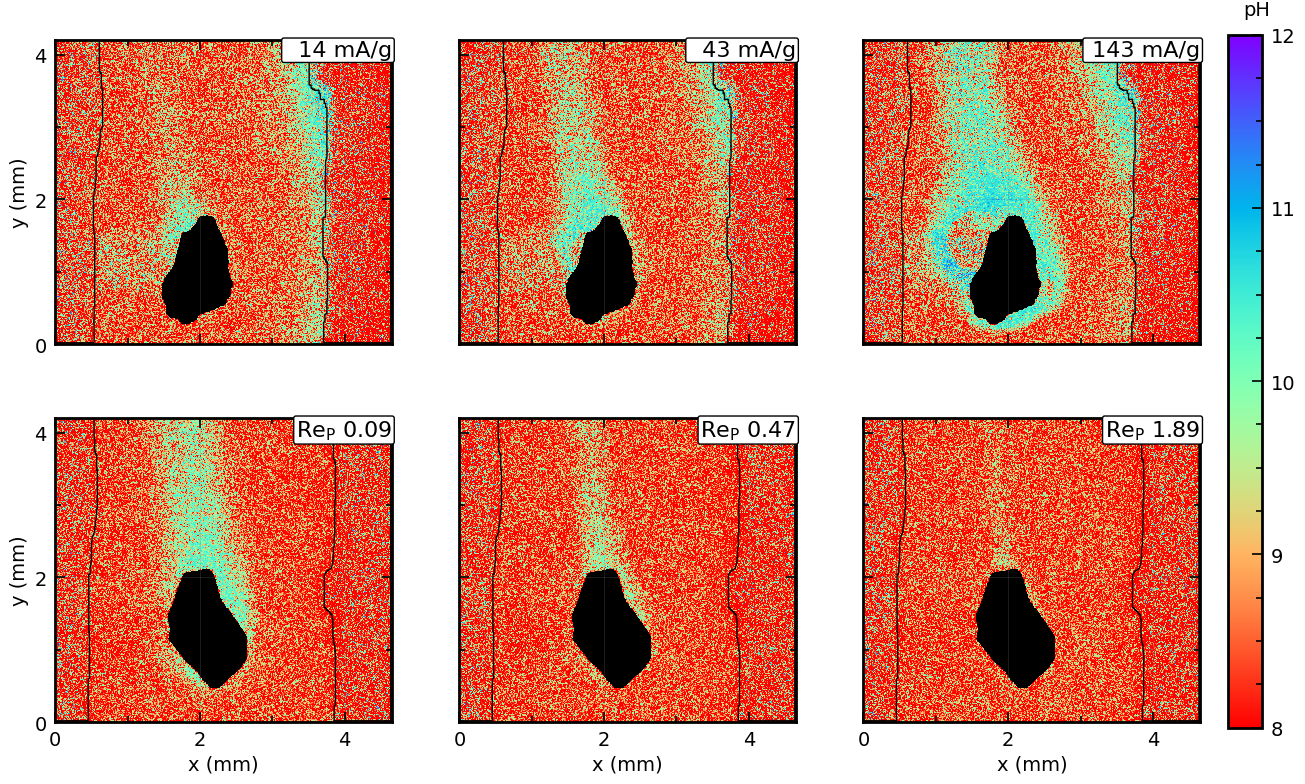

In [76]:
ncols = 3
nrows = 2

current_bool_frames = [i in [2, 5, 9] for i in range(len(current_flim_frames))]
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(17.8, 9))

axes.flat[0].xaxis.set_major_locator(ticker.MultipleLocator(2))
axes.flat[0].yaxis.set_major_locator(ticker.MultipleLocator(2))
axes.flat[0].xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
axes.flat[0].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

for i in [0, 3]:
    axes.flat[i].set_ylabel("y (mm)")

for i in [3, 4, 5]:
    axes.flat[i].set_xlabel("x (mm)")

"""Current"""
for i, (i_frame, time_stamp) in enumerate(
    zip(
        [
            current_flim_frames[i]
            for i in range(len(current_flim_frames))
            if current_bool_frames[i]
        ],
        [
            current_time_stamps[i]
            for i in range(len(current_time_stamps))
            if current_bool_frames[i]
        ],
    )
):
    print(
        i,
        current_ivium.I[current_ivium.t < time_stamp][-1] / mass_particle_AC,
    )
    ax = axes.flat[i]
    img = ax.imshow(
        current_data["value"][i_frame], vmin=8, vmax=12, cmap="rainbow_r", extent=extent
    )
    ax.imshow(current_particle.transparent_mask, extent=extent, cmap="gray")
    gpd.GeoSeries(
        fa.affine_transform_pixel2extent(
            current_membrane.geometry, geom_extent, list(extent)
        )
    ).exterior.plot(ax=ax, color="black", lw=1)
    gpd.GeoSeries(
        fa.affine_transform_pixel2extent(
            current_wall.geometry, geom_extent, list(extent)
        )
    ).exterior.plot(ax=ax, color="black", lw=1)
    ax.text(
        1,
        1,
        f"{abs(current_ivium.I[current_ivium.t < time_stamp][-1]) / mass_particle_AC:4.0f} "
        + r"mA/g",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.1"),
        horizontalalignment="right",
        verticalalignment="top",
        transform=ax.transAxes,
    )


"""Flow"""
count = 0
for i, (i_frame, Re) in enumerate(zip(flow_flim_frames, Res)):
    if i not in [0, 2, 7]:
        continue
    ax = axes.flat[3 + count]
    print(i, i_frame, Re)
    img = ax.imshow(
        flow_data["value"][i_frame],
        vmin=8,
        vmax=12,
        cmap="rainbow_r",
        extent=extent,
    )
    count += 1
    ax.imshow(flow_particle.transparent_mask, extent=extent, cmap="gray")
    gpd.GeoSeries(
        fa.affine_transform_pixel2extent(
            flow_membrane.geometry, geom_extent, list(extent)
        )
    ).exterior.plot(ax=ax, color="black", lw=1)
    gpd.GeoSeries(
        fa.affine_transform_pixel2extent(flow_wall.geometry, geom_extent, list(extent))
    ).exterior.plot(ax=ax, color="black", lw=1)
    ax.text(
        1,
        1,
        f"$Re_P$ {Re:>4.2f}",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.1"),
        horizontalalignment="right",
        verticalalignment="top",
        transform=ax.transAxes,
    )

clb = fig.colorbar(img, ax=axes.ravel().tolist(), pad=0.02)
clb.set_label("pH", labelpad=-28, y=1.05, rotation=0)
clb.ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
clb.ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(4))

fig.savefig(os.path.join(figures_folder, "figure04.png"), dpi=100)
plt.show()